In [ ]:
import pandas as pd
import numpy as np

# Load the data
file_path = '/content/AAPL.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-05-28,32.965000,32.987499,32.775002,32.945000,29.692596,122933200
1,2015-05-29,32.807499,32.862499,32.474998,32.570000,29.354616,203538000
2,2015-06-01,32.570000,32.847500,32.512501,32.634998,29.413195,128451200
3,2015-06-02,32.465000,32.665001,32.330002,32.490002,29.282515,134670400
4,2015-06-03,32.665001,32.735001,32.474998,32.529999,29.318565,123934000


In [ ]:
# Preprocess the data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data['Close']

# Split the data into training and testing sets (80:20 ratio)
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

train.head(), test.head()


(Date
 2015-05-28    32.945000
 2015-05-29    32.570000
 2015-06-01    32.634998
 2015-06-02    32.490002
 2015-06-03    32.529999
 Name: Close, dtype: float64,
 Date
 2019-05-29    44.345001
 2019-05-30    44.575001
 2019-05-31    43.767502
 2019-06-03    43.325001
 2019-06-04    44.910000
 Name: Close, dtype: float64)

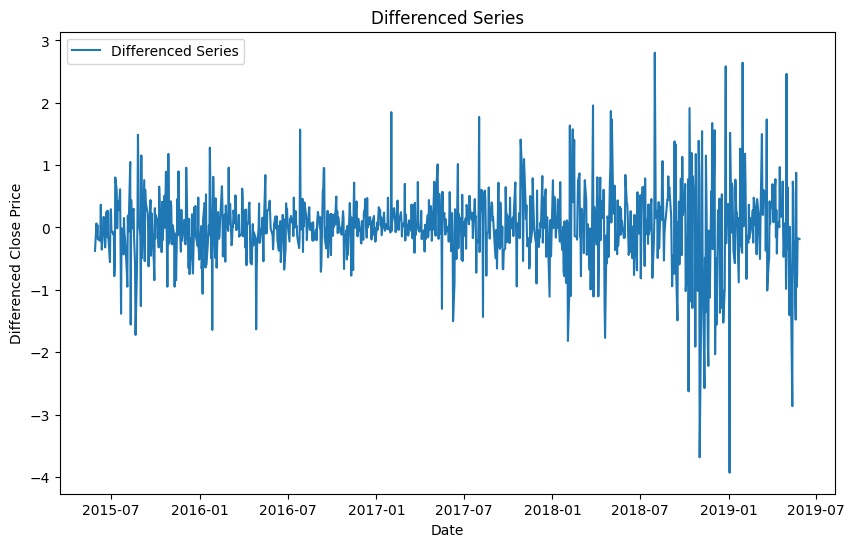

In [ ]:
# Differencing the series
train_diff = train.diff().dropna()

# Plotting the differenced series
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_diff, label='Differenced Series')
plt.title('Differenced Series')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()


In [ ]:
# Initialize parameters for ARIMA(1,1,1)
p, d, q = 1, 1, 1

# Differencing the test data
test_diff = test.diff().dropna()

# ARIMA Model Prediction
def arima_forecast(train, test, p, d, q):
    history = list(train)
    predictions = []
    for t in range(len(test)):
        # Differencing
        diffed_value = history[-1] - history[-d] if d > 0 else history[-1]

        # AR component
        ar_part = sum(history[-i-1] for i in range(p)) / p if p > 0 else 0

        # MA component
        if len(predictions) > 0:
            ma_part = sum(predictions[-i-1] for i in range(q)) / q if q > 0 else 0
        else:
            ma_part = 0

        # Forecast
        forecast = diffed_value + ar_part + ma_part
        predictions.append(forecast)
        history.append(test.iloc[t])

    return predictions

In [ ]:
# Making predictions
predictions = arima_forecast(train_diff, test_diff, p, d, q)

# Reverse differencing to get actual predictions
def reverse_difference(predictions, original_data, d):
    forecast = []
    for i in range(len(predictions)):
        if d > 0:
            forecast.append(predictions[i] + original_data[i])
        else:
            forecast.append(predictions[i])
    return forecast

# Reverse differencing
forecasted_values = reverse_difference(predictions, list(test)[:len(predictions)], d)


Root Mean Squared Error: 21.559812756633928


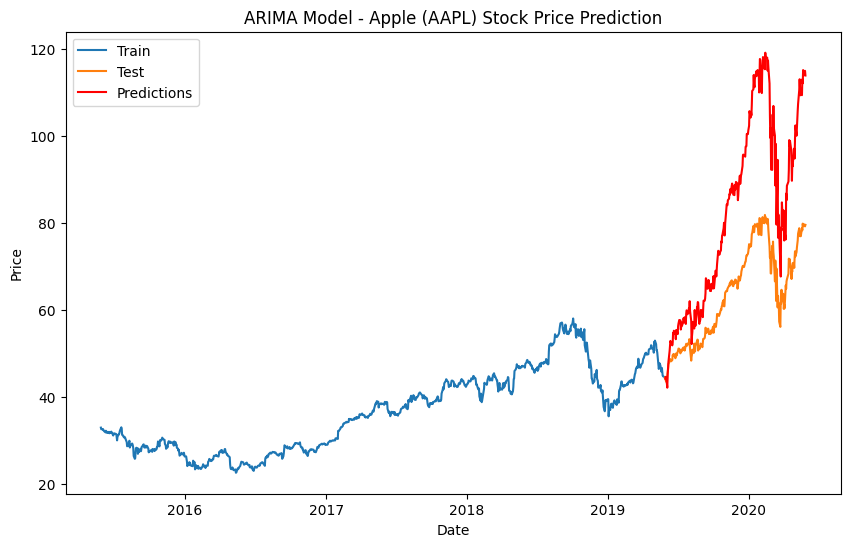

In [ ]:
# Evaluating the model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test[d:], forecasted_values)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index[d:], forecasted_values, label='Predictions', color='red')
plt.title('ARIMA Model - Apple (AAPL) Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()